<a href="https://colab.research.google.com/github/birumusa/MTS.Teta-HW-2/blob/main/meal_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meal Demand Forecasting

**HW 2. MTS.Teta Summer School**

[Ссылка на соревнование](https://www.kaggle.com/sureshmecad/meal-demand-forecasting)

**Команда BTE (Best Team Ever):**

* `Анастасия Барабанова`
* `Александр Воробьев`
* `Рафаэль Рамазанов`
* `Даниэль Биру Муса`
* `Шамиль Нуркаев`

---

**Описание бизнес-задачи:**

- Компания по доставке еды имеет различные центры выполнения заказов в нескольких городах. Она хочет, чтобы мы помогли этим центрам **в прогнозировании спроса на 1 ближайшую неделю**, чтобы правильно спланировать запасы продуктов. Также компания просит оценить *экономический эффект* и *точность нашего прогноза*, чтобы понимать, насколько хорош наш алгоритм и насколько можно ему доверять.

- В данном случае необходима оптимизация логистического бизнес-процесса, чтобы эффективно использовать складские помещения и поддерживать оптимальный объем продукции.

**Бизнес-цель:** 

- Оптимизация расчётов потребностей складов в продукции для минимизации возможных потерь.

- Оценка успешности будет происходить с помощью измерения объёма невостребованной продукции на складе и нехватившей продукции, вызвавшей неудовлетворённый спрос. *Критерий успеха:* предсказанный спрос удовлетворяет существующие потребности клиентов, при этом невостребованных запасов на складе должно быть сведено к минимуму.

Это было описание бизнес-кейса. Давайте теперь сформулируем математическую постановку задачи данного бизнес-кейса.

--- 

**Математическая постановка задачи:** 

- Разработка модели машинного обучения на основании данных о динамике спроса в прошлом путем изучения объемов продаж за определенный период времени для решения задачи регрессии по предсказанию спроса на продукцию компании на 1 неделю. Вероятностная модель не требуется. 

- Модель может быть интегрирована в рабочую среду отвественных за расчёт потребностей в продукции складов в виде дополнительной программы. Далее это может быть использовано для организации доставки продукции до складов.

**Метрика качества:**

- Будет использована **MAPE**, поскольку данная метрика может быть легко интерпретирована для бизнес-целей как процент ошибки относительно истинного ответа

---

**Актуальность задачи:**

- Запасы продукции – это залог того, что компания получает прибыль, а значит, её бизнес процветает, поэтому нужно точно знать, когда и сколько её нужно закупить.

- Для компании по доставке еды важно правильное планирование закупок. Если не учесть этот момент, то можно столкнуться с проблемой нехватки или излишка товара и, как следствие, с убытками. Необходимо соблюдать баланс между количеством запасов и оборотом, в котором они используются. С одной стороны, запасов продуктов на складах должно быть достаточно, чтобы удовлетворить существующие потребности клиентов. С другой стороны, неправильное планирование запасов ведёт к тому, что много невостребованной продукции, хранящейся на одном из складов, может стать непригодной к употреблению (истечение срока годности), что приведёт к дополнительным расходам на утилизацию. 

In [ ]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm.auto import tqdm

# Set up Screen output
pd.set_option('display.max_columns', 200)

import matplotlib.pyplot as plt
import seaborn as sns
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Игнорируем назойливые предупреждения
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

In [ ]:
!pip install -q catboost

In [ ]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 0.24.2
Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


In [ ]:
from termcolor import cprint # For making colorful printing texts

import scipy.stats as sps
from scipy.special import inv_boxcox

from sklearn.model_selection import train_test_split, GridSearchCV

from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import math 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 0: Data

Перед нами данные из реальной жизни. Поэтому какие-то товары могут быть очень новыми и у них слишком короткая история для прогнозирования продаж для них. Некоторые товары дорогие и покупаются не каждую неделю/месяц. В общем все, что присуще продажам товаров в магазинах.

Однако у нас большая тренировочная выборка (целых 145 недель), что может позволить нам хорошо спрогнозировать спрос на непопулярные товары.

In [ ]:
DATA_DIR = "/content/"

train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

meal_info = pd.read_csv(os.path.join(DATA_DIR, "meal_info.csv"))
fulfilment_center_info = pd.read_csv(os.path.join(DATA_DIR, "fulfilment_center_info.csv"))


In [ ]:
# making colorful printing texts
print('\nShape of the Train set:', train.shape)
cprint('*'*35, 'green')

print('\nShape of the Test set:', test.shape)
cprint('*'*35, 'green')

print('\nShape of the Meal Info set:', meal_info.shape)
cprint('*'*35, 'green')

print('\nShape of the Fulfilment Center Info set:', fulfilment_center_info.shape)
cprint('*'*35, 'green')



Shape of the Train set: (456548, 9)
***********************************

Shape of the Test set: (32573, 8)
***********************************

Shape of the Meal Info set: (51, 3)
***********************************

Shape of the Fulfilment Center Info set: (77, 5)
***********************************


### `train` & `test`

Исторические данные о спросе на комбинацию "продукт-центр" (недели: от 1 до 145):

- `id` - Unique ID
- `week` - Week No
- `center_id` - Unique ID for fulfillment center
- `meal_id` - Unique ID for Meal
- `checkout_price` - Final price including discount, taxes & delivery charges
- `base_price` - Base price of the meal
- `emailer_for_promotion` - Emailer sent for promotion of meal
- `homepage_featured` - Meal featured at homepage
_____________________________________________________________________
- **`num_orders`** - (Target) Orders Count (в train)

In [ ]:
train

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40
...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68
456544,1062036,145,61,2304,482.09,482.09,0,0,42
456545,1110849,145,61,2664,237.68,321.07,0,0,501
456546,1147725,145,61,2569,243.50,313.34,0,0,729


In [ ]:
test

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0
...,...,...,...,...,...,...,...,...
32568,1250239,155,61,1543,482.09,484.09,0,0
32569,1039516,155,61,2304,483.09,483.09,0,0
32570,1158107,155,61,2664,322.07,323.07,0,0
32571,1444235,155,61,2569,322.07,323.07,0,0


### `meal_info`

Характеристики продуктов (еды), такие как категория и кухня:

- `meal_id` - Unique ID for the meal
- `category` - Type of meal (beverages/snacks/soups….)
- `cuisine` - Meal cuisine (Indian/Italian/…)

In [ ]:
pd.concat((meal_info.head(), 
           meal_info.tail()))

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian
46,2956,Fish,Continental
47,2104,Fish,Continental
48,2444,Seafood,Continental
49,2867,Seafood,Continental
50,1445,Seafood,Continental


### `fulfilment_center_info`

Информация о центрах выполнения, такая как площадь центра, информация о городе и т.д.

- `center_id` - Unique ID for fulfillment center
- `city_code` - Unique code for city
- `region_code` - Unique code for region
- `center_type` - Anonymized center type
- `op_area` - Area of operation (in km^2)

In [ ]:
fulfilment_center_info

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6
...,...,...,...,...,...
72,53,590,56,TYPE_A,3.8
73,30,604,56,TYPE_A,3.5
74,76,614,85,TYPE_A,3.0
75,68,676,34,TYPE_B,4.1


# Part I: Preparation

Объединим данные со всех таблиц в один датафрейм `all_data`

In [ ]:
all_data = train.merge(meal_info, on="meal_id", how="left").merge(
                       fulfilment_center_info, on="center_id", how="left")
test = test.merge(meal_info, on="meal_id", how="left").merge(
                   fulfilment_center_info, on="center_id", how="left")

display(all_data, test)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,Indian,473,77,TYPE_A,4.5
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,Indian,473,77,TYPE_A,4.5
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,Italian,473,77,TYPE_A,4.5
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,Italian,473,77,TYPE_A,4.5


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
0,1028232,146,55,1885,158.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
1,1127204,146,55,1993,160.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
2,1212707,146,55,2539,157.14,159.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0
3,1082698,146,55,2631,162.02,162.02,0,0,Beverages,Indian,647,56,TYPE_C,2.0
4,1400926,146,55,1248,163.93,163.93,0,0,Beverages,Indian,647,56,TYPE_C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32568,1250239,155,61,1543,482.09,484.09,0,0,Desert,Indian,473,77,TYPE_A,4.5
32569,1039516,155,61,2304,483.09,483.09,0,0,Desert,Indian,473,77,TYPE_A,4.5
32570,1158107,155,61,2664,322.07,323.07,0,0,Salad,Italian,473,77,TYPE_A,4.5
32571,1444235,155,61,2569,322.07,323.07,0,0,Salad,Italian,473,77,TYPE_A,4.5


Число столбцов в `all_data` по типу. Как видно, все признаки имеют числовой тип. Однако, некоторые из них фактически являются категориальными. Для нашего удобства создадим списки с именами категориальных и числовых признаков.

In [ ]:
all_data.dtypes.value_counts()

int64      9
float64    3
object     3
dtype: int64

In [ ]:
all_data.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area'],
      dtype='object')

In [ ]:
all_data["op_area"].value_counts()

4.0    52548
3.9    48533
3.8    40080
4.4    26060
4.5    25688
2.8    25503
4.1    23346
7.0    20686
4.8    18648
3.4    17258
3.6    16821
5.1    13366
4.2    12608
2.7    12430
3.0    11184
2.0     9512
6.7     7046
6.3     7015
5.6     6993
3.7     6801
3.5     6666
3.2     6333
5.0     6164
5.3     6053
4.6     5983
4.7     5975
2.4     5021
2.9     4712
1.9     4083
0.9     3432
Name: op_area, dtype: int64

In [ ]:
all_data["op_area"] = (all_data["op_area"] * 10).astype(int)

In [ ]:
# Категориальные признаки
cat_features = [
        "center_id", "meal_id", "emailer_for_promotion", 
        "homepage_featured", "category", "cuisine", 
        "city_code", "region_code", "center_type"
]
# Числовые признаки
num_features = ["week", "checkout_price", "base_price", "op_area"]
# Все признаки
feature_cols = num_features + cat_features
# Целевая переменная
target_col = 'num_orders'

In [ ]:
X = all_data[feature_cols]
Y = all_data[target_col]
# После выделения названий признаков в список, порядок столбцов изменился
test = test[feature_cols]

# Part II: EDA

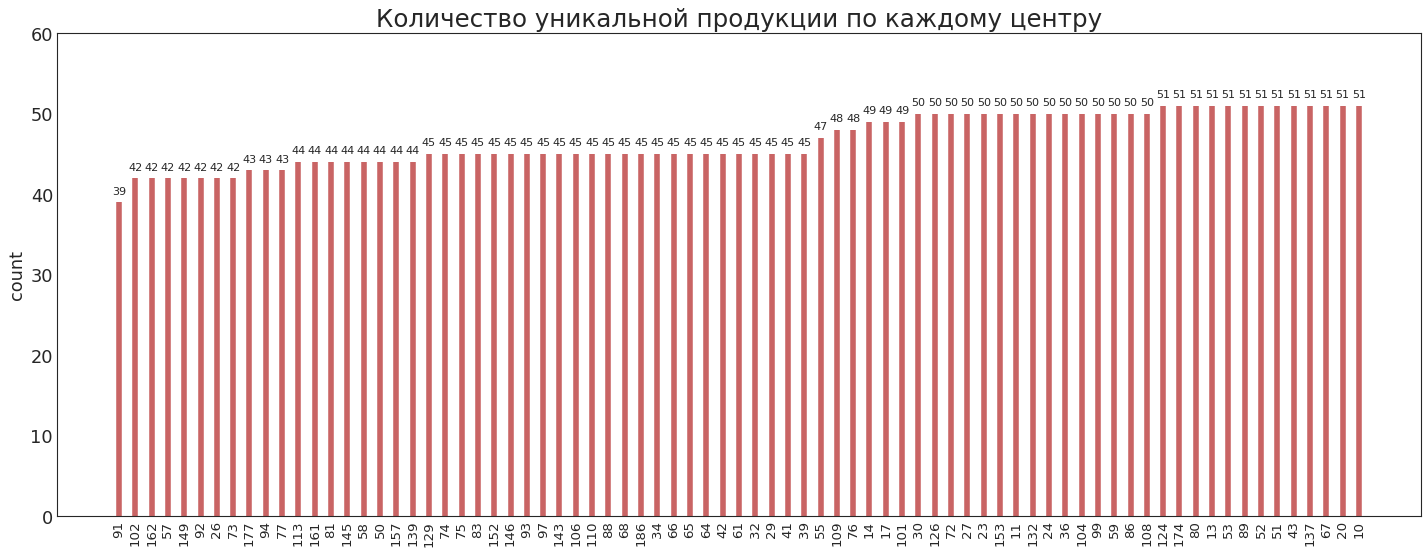

In [ ]:
df = X[["center_id", "meal_id"]].groupby("center_id").nunique()
df.sort_values('meal_id', inplace=True)
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(22,8), facecolor='white', dpi= 80)
ax.vlines(x=df.index, ymin=0, ymax=df.meal_id, color='firebrick', alpha=0.7, linewidth=5)

# Annotate Text
for i, meal_id in enumerate(df.meal_id):
    ax.text(i, meal_id+1, meal_id, horizontalalignment='center')


# Title, Label, Ticks and Ylim
ax.set_title('Количество уникальной продукции по каждому центру', fontdict={'size':22})
ax.set(ylabel='count', ylim=(0, 60))
plt.xticks(df.index, df.center_id, rotation=90, horizontalalignment='center', fontsize=12)

plt.show()

### 2.1 Исследование данных на наличие пропусков и некорректных значений. 

**Либо удалим их, либо сделаем imputing (проинтерполируем).**


Данные могут иметь пропущенные значения не случайно, а в виду некоторых закономерностей. В таких случаях пропуски можно выразить на основе информации, содержащейся в наборе данных. Благодаря описанию данных, приложенных к соревнованию, можно заменить их подходящими значениями.

In [ ]:
cprint("Dtypes in Train :", 'green')
cprint('*'*35, 'green')
print('\n', X.info())

cprint("Dtypes in Test :", 'green')
cprint('*'*35, 'green')
print('\n', test.info())

Dtypes in Train :
***********************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   week                   456548 non-null  int64  
 1   checkout_price         456548 non-null  float64
 2   base_price             456548 non-null  float64
 3   op_area                456548 non-null  int64  
 4   center_id              456548 non-null  int64  
 5   meal_id                456548 non-null  int64  
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   category               456548 non-null  object 
 9   cuisine                456548 non-null  object 
 10  city_code              456548 non-null  int64  
 11  region_code            456548 non-null  int64  
 12  center_type            456548 non-null  object 
dtypes: float64(2), int64(8), object(3)


### 2.2 Распределение целевой переменной. Поиск аномалий.

**Можно убрать выбросы из датасета или преобразовать целевую переменную (например, посредством преобразования Бокса-Кокса).**

count    456548.000000
mean        261.872760
std         395.922798
min          13.000000
25%          54.000000
50%         136.000000
75%         324.000000
max       24299.000000
Name: num_orders, dtype: float64

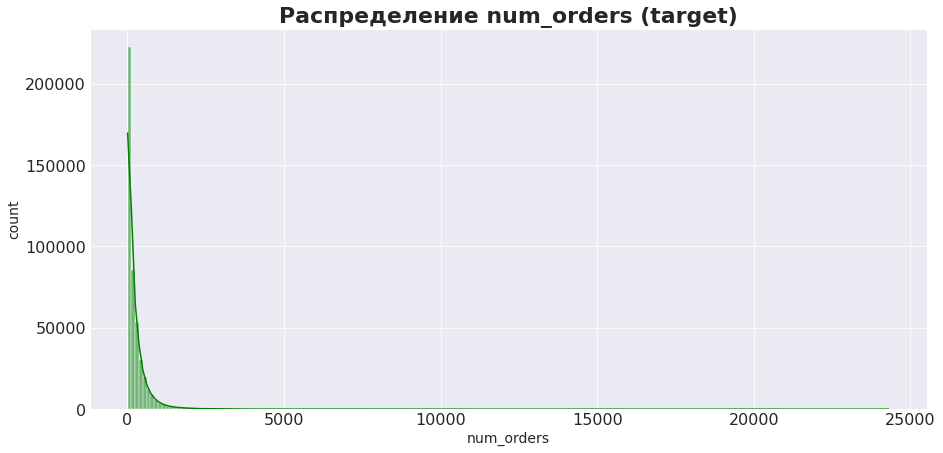

In [ ]:
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(15,7))

    sns.histplot(data=Y, bins=200, kde=True, color="Green")
    
    plt.title("Распределение num_orders (target)", fontsize = 22, fontweight="bold")
    plt.xlabel("num_orders", fontsize=14)
    plt.ylabel('count', fontsize=14)    

    display(Y.describe())
    
    plt.show()

In [ ]:
# display(Y[Y >= 1000].shape[0])
# display(Y[Y >= 700].shape[0])
# display(Y[Y >= 600].shape[0])

display(Y.shape[0], Y[Y >= 900].shape[0])
display(np.quantile(Y, 0.95))

456548

21828

878.0

In [ ]:
Y, lambda_boxcox = sps.boxcox(Y)
Y = pd.Series(Y, name=target_col)

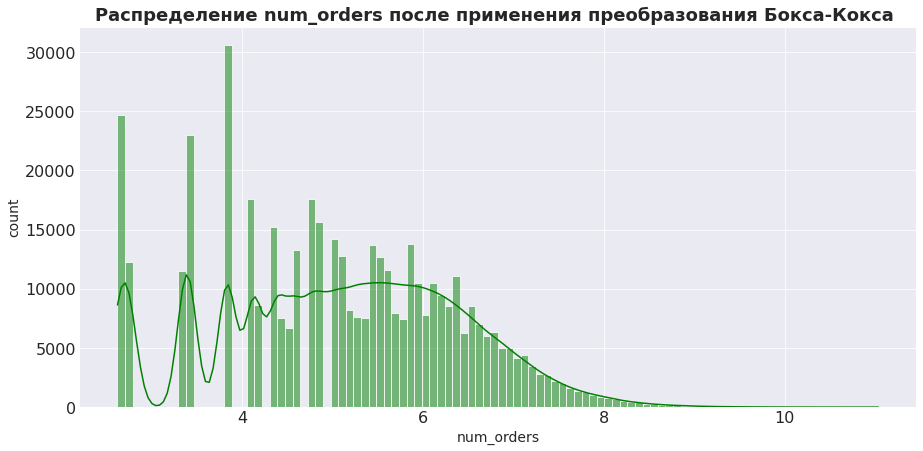

In [ ]:
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(15,7))

    sns.histplot(data=Y, bins=100, kde=True, color="Green")
    
    plt.title("Распределение num_orders после применения преобразования Бокса-Кокса ", 
              fontsize = 18, fontweight="bold")
    plt.xlabel("num_orders", fontsize=14)
    plt.ylabel('count', fontsize=14)

    plt.show()

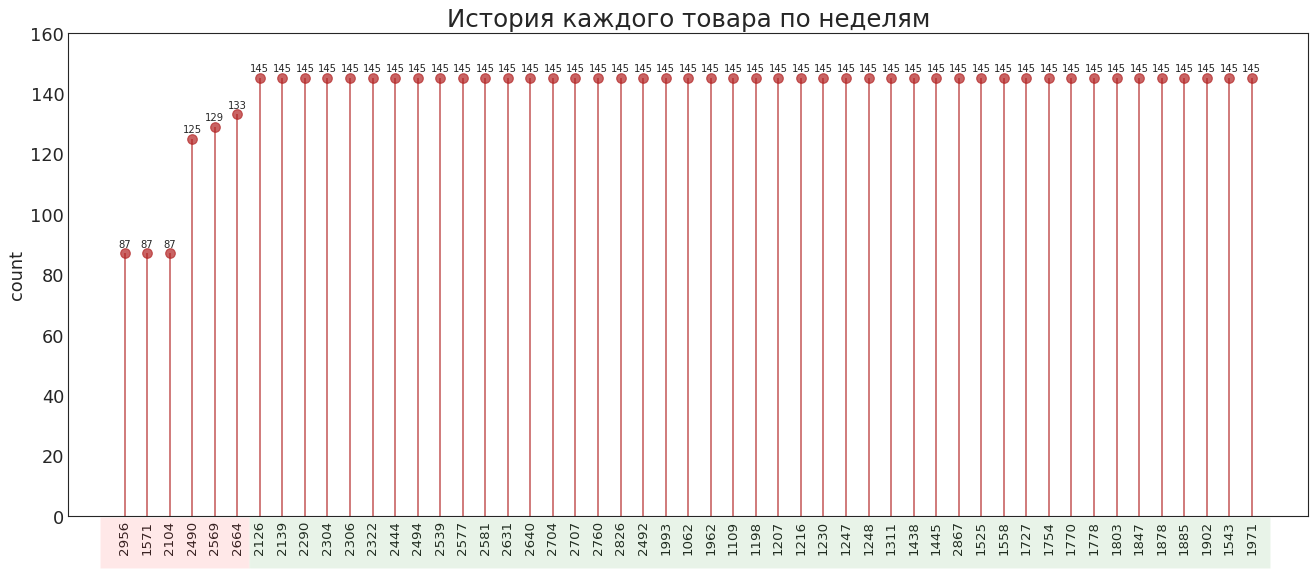

In [ ]:
# Prepare Data
df = X[["meal_id", "week"]].groupby('meal_id').nunique()
df.sort_values('week', inplace=True)
df.reset_index(inplace=True)

# Draw plot
fig, ax = plt.subplots(figsize=(20,8), dpi= 80)
ax.vlines(x=df.index, ymin=0, ymax=df.week, color='firebrick', alpha=0.7, linewidth=1.5)
ax.scatter(x=df.index, y=df.week, s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title("История каждого товара по неделям")
ax.set_ylabel('count')
ax.set_xticks(df.index)
ax.set_xticklabels(df.meal_id, rotation=90, fontdict={'horizontalalignment': 'center', 'size':12})
ax.set_ylim(0, 160)

# Draw plot
import matplotlib.patches as patches

# Annotate
for row in df.itertuples():
    ax.text(row.Index, row.week+1.5, s=row.week, horizontalalignment= 'center', verticalalignment='bottom', fontsize=9)

# Add patches to color the X axis labels
p1 = patches.Rectangle((.145, 0.044), width=.093, height=.08, alpha=.09, facecolor='red', transform=fig.transFigure)
p2 = patches.Rectangle((.238, 0.044), width=.638, height=.08, alpha=.09, facecolor='green', transform=fig.transFigure)
fig.add_artist(p1)
fig.add_artist(p2)
plt.show()

Видим, что не по всем товарам есть полная история в 145 недель (`2956`, `1571`, `2104`, `2490`, `2569`, `2664`). Тем не менее, история всё равно большая

In [ ]:
print("Всего уникальных центров:", X.center_id.nunique())
print("Всего уникальных видов еды:", X.meal_id.nunique())

Всего уникальных центров: 77
Всего уникальных видов еды: 51


**Вывод по данным:**

В обучающей выборке отсутствуют пропуски, но были обнаружены выбросы.

При этом в категориальных признаках наблюдается существенный дисбаланс, что может повлиять на возможность модели получить значимую связь между целевой переменной и данными признаками.

Количество заказов имеет отрицательную корреляцию со следующими признаками:

* итоговая цена и базовая цена (при этом между данными показателями также наблюдается высокая положительная корреляция)

Количество заказов имеет положительную корреляцию со следующими признаками:

* отправка промо по e-mail и показы продукции на главной странице (при этом между данными показателями также наблюдается высокая положительная корреляция)

 

Объём выборки позволяет провести обучение (456548), что говорит о её достаточности.

Непротиворечивость данных не наблюдается.

Удовлетворяет ли ожиданиям? 

Необходимо провести предобработку датасета перед обучением. Также необходимо расширить датасет с положительными примерами по промоакциям и наличию товара на главной странице сайта, либо убрать эту информацию совсем.

Возможно, стоит перейти от просто порядкового перечисления недели к неделе в месяце и конкретному месяцу, чтобы модель смогла найти новые закономерности

# Part III: Prediction

## 3.1 Прогнозирование среднего значения количества заказов для каждого склада

In [ ]:
class AveragePredictor():
    def __init__(self):
        self.predictions = pd.DataFrame()
        
    def fit(self, df):
        self.predictions = df.groupby(['center_id', 'meal_id'], as_index=False).agg({'num_orders':'mean'})
        self.predictions["num_orders"] = self.predictions["num_orders"].apply(lambda x: math.ceil(x))
        
    def predict(self, df):
        df_for_pred = df.loc[:, ['center_id', 'meal_id']].drop_duplicates()
        preds = df_for_pred.merge(self.predictions, on=['center_id', 'meal_id'], how='inner')
        return preds

In [ ]:
# подготовка данных для обучения и теста
border = int(0.8 * len(train))
train_shuffle = train.sample(frac=1)

# обучение модели
avg_pred = AveragePredictor()
avg_pred.fit(train_shuffle[:border])

# обучение модели
avg_pred = AveragePredictor()
avg_pred.fit(train_shuffle[:border])# предсказания
y_pred = avg_pred.predict(train_shuffle[border:])

# проверка качества
for_test = train_shuffle[['center_id', 'meal_id', 'num_orders']]
for_test = for_test.merge(y_pred, how='inner', on=['center_id', 'meal_id'], suffixes=['_true', '_pred'])
mean_absolute_percentage_error(for_test.num_orders_true, for_test.num_orders_pred)

0.764439039227062

## 3.2 Random forest

In [ ]:
x = train.iloc[:, :-1]
y = train.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=103)

In [ ]:
model = RandomForestRegressor(n_estimators=200)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

0.5562830497857568

## 3.3 CatBoost

In [ ]:
catboost_params = {'depth': 4,
                   'l2_leaf_reg': 1,
                   'custom_metric': 'MAPE',
                   'task_type': 'GPU',
                   'iterations': 1100,
                   'devices': '0',
                   'verbose': 100,
                   'random_seed': 2021}

kf = KFold(n_splits=5)
scores = []
Y_predict = []
MAPE_metrics = []

for train_index, test_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_valid = Y.iloc[train_index], Y.iloc[test_index]

    model = CatBoostRegressor(**catboost_params)
    model = model.fit(X_train, Y_train,
                      cat_features=cat_features,
                      eval_set=(X_valid, Y_valid),
                      use_best_model=True)
    MAPE_metrics.append(model.best_score_["validation"]["MAPE"])
    
    scores.append(model.score(X_valid, Y_valid))
    Y_predict.append(model.predict(test))

0:	learn: 1.2991352	test: 1.3073337	best: 1.3073337 (0)	total: 40.8ms	remaining: 44.8s
100:	learn: 0.6699146	test: 0.6813299	best: 0.6813299 (100)	total: 2.87s	remaining: 28.4s
200:	learn: 0.6304904	test: 0.6533469	best: 0.6533469 (200)	total: 5.57s	remaining: 24.9s
300:	learn: 0.6154663	test: 0.6423760	best: 0.6423760 (300)	total: 8.29s	remaining: 22s
400:	learn: 0.6053804	test: 0.6333911	best: 0.6333911 (400)	total: 10.9s	remaining: 19s
500:	learn: 0.5972005	test: 0.6280313	best: 0.6280279 (498)	total: 13.5s	remaining: 16.2s
600:	learn: 0.5905332	test: 0.6226667	best: 0.6226667 (600)	total: 16.2s	remaining: 13.4s
700:	learn: 0.5857003	test: 0.6190484	best: 0.6190012 (697)	total: 18.8s	remaining: 10.7s
800:	learn: 0.5815530	test: 0.6162725	best: 0.6162725 (800)	total: 21.4s	remaining: 7.99s
900:	learn: 0.5783753	test: 0.6136663	best: 0.6136646 (899)	total: 24s	remaining: 5.3s
1000:	learn: 0.5756182	test: 0.6116067	best: 0.6116067 (1000)	total: 26.6s	remaining: 2.63s
1099:	learn: 0.573

In [ ]:
mean_score = np.mean(scores)
Y_predict = np.mean(Y_predict, axis=0)
print(mean_score) # R^2 (R square) score

0.798376627720365


In [ ]:
np.mean(MAPE_metrics)

0.10448736657633484

 Метрика MAPE говорит нам о том, что в среднем прогноз модели ошибается на 10%. 

 Данная модель оптимальна как по результату метрики качества, так и по времени обучения

# Экономический эффект

В случае успешной реализации проекта ожидается получить следующий экономический эффект:

$$E = \sum(C - RM)*p, C >= RM$$

где E - экономический эффект, в ден.ед.,

C - рассчитанная потребность, в ед.

RM - реализованная продукция, в ед.

p - стоимость продукции, в ден.ед.

E - это невостребованный остаток, может добавить дополнительные затраты. Стремимся получить Е = 0. 

В зависимости от качества модели остаток может быть рассчитан либо более приближенным к реальным результатам, либо сильно отличающимся от него.

Если взять CatBoost модель, то модель ошибается в среднем на 10% как в сторону недостачи, так и в сторону переизбытка продукции на складе.

Как измениться эффект от роста качества на 1% / 10%

Рост качества модели на 1% позволит сократить ошибку модели на 1%, т.е. разброс сократиться на 1%. Соотвественно, аналогичная ситуация будет и с 10%. 
